# Group 22 Final Report

### Group Members:

Kaiser Ninomiya (41514506)

Patrick Cui (39674692)

Uday Kapoor (21201249)

Viet Ngo (71724082)

## Gender Wage Disparities in the United States: A Comparative Analysis

### Table of Contents

- [Introduction](#Introduction)
- [Methods and Results](#Methods-and-Results)
    - [Data Wrangling](#Data-Wrangling)
    - [Plotting of Relevant Variables](#Plotting-of-Relevant-Variables)
    - [Hypothesis Testing - Asymptotic Method](#)
    - [Hypothesis Testing - Bootstrapping Method](#)
- [References](#References)

# Introduction

The proposed project aims to investigate gender wage disparities in the United States using a dataset containing information on various demographic and employment-related variables. The primary question we seek to answer is whether there is a significant difference in wages between male and female workers, specifically whether male workers more likely to earn more than their female counterparts. We will focus on the hourly wage as our main variable of interest to compare across the two genders. By analyzing this dataset, we aim to shed light on existing gender wage gaps and assess the potential impact of such disparities.
Our project aims to investigate gender wage disparities in the United States using a dataset containing information on various demographic and employment-related variables. We seek to answer whether there is a significant difference in wages between male and female workers.

For this report, we will use the mean as the parameter of interest. Although the distribution of wages is known to be right-skewed, the median would be a better choice. However, we do not yet have the tool to use asymptotic method on the median, hence our choice of the mean. From our question, we formally state the hypotheses as follow:
$$H_{0}: \mu_{\text{male}} = \mu_{\text{female}}$$ $$H_{1}: \mu_{\text{male}} > \mu_{\text{female}}$$ $$\text{Confidence level: 0.95}$$
Where $\mu_{\text{male}}$ and $\mu_{\text{female}}$ are the mean wage for men and women respectively. We choose the confidence level to be 0.95 because it is a common value used for hypothesis testing. In addition, we are not making any high-risk decisions based on the result of this test so a higher p-value is not needed.

# Methods and Results

## Data Wrangling

In [132]:
library(infer)
library(repr)
library(readr)
library(tidyverse)
library(RColorBrewer)

library(cowplot)
library(datateachr)
library(digest)
library(taxyvr)
library(broom)
library(testthat)
library(infer)

We have successfully imported and cleaned the dataset, ensuring that the data is in a tidy format for analysis. We have also plotted the raw data, specifically examining the distribution of hourly wages for male and female workers. In the preliminary analysis, we observed that there is a clear difference in the distribution of hourly wages between males and females.

In [133]:
raw_data <- read_csv('https://github.com/AVietCong/stat201-group22-project/raw/main/Gender_Pay_Gap_dataset.csv')
raw_data$occupation <- colnames(raw_data[,106:127])[apply(raw_data[,106:127], 1, which.max)]

filtered_data <- select(raw_data, sex, race, hrwage, incwage, sch, wkswork1, uhrswork, potexp, occupation) %>%
    mutate(sex = as.factor(sex),
           race = as.factor(race),
           hrwage = as.double(hrwage),
           incwage = as.double(incwage),
           sch = as.double(sch),
           wkswork = as.integer(wkswork1),
           uhrswork = as.integer(uhrswork),
           potexp = as.integer(potexp),
           occupation = as.factor(occupation))

head(filtered_data)
print("Table 1.1 - Filtered gender paygap table")

Rows: 53790 Columns: 129
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): adj_occ2name
dbl (127): year, serial, numprec, gq, region, statefip, metro, metarea, coun...
lgl   (1): farm

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sex,race,hrwage,incwage,sch,wkswork1,uhrswork,potexp,occupation,wkswork
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>
1,1,24.913,57000,14,52,44,42,healthcare,52
1,1,31.000,62000,13,50,40,40,constructextractinstall,50
1,3,21.635,45000,12,52,40,26,architect,52
1,1,12.821,28000,12,52,42,23,manager,52
1,1,21.250,42500,12,50,40,17,transport,50
1,1,21.875,35000,11,40,40,18,constructextractinstall,40


[1] "Table 1.1 - Filtered gender paygap table"


We have narrowed down the dataset to focus only on the variables of interest: namely sex, race, hourly wage(hrwage), total income (incwage), schooling years (sch), occupation, weeks worked (wkswork1), and usual hours worked (uhrswork).

In [134]:
pay_data <- filtered_data %>%
    mutate(sex = fct_recode(sex, 'male' = '1', 'female' = '2'),
           race = fct_recode(race, 'White' = '1', 'Black' = '2', 'Hispanic' = '3', 'Other' = '4'),
           education_level = case_when(sch == 0 ~ 'None',
                                       sch < 12 ~ 'Incomplete Schooling', 
                                       sch == 12 ~ 'Highschool',
                                       sch == 13 ~ 'College',
                                       sch == 14 ~ 'Associate Degree',
                                       sch <= 16 ~ 'BA',
                                       sch <= 18 ~ 'Advanced Degree')) %>%
    select(-sch)
head(pay_data)
print("Table 1.2 - Gender paygap table with education level")

sex,race,hrwage,incwage,wkswork1,uhrswork,potexp,occupation,wkswork,education_level
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>,<chr>
male,White,24.913,57000,52,44,42,healthcare,52,Associate Degree
male,White,31.000,62000,50,40,40,constructextractinstall,50,College
male,Hispanic,21.635,45000,52,40,26,architect,52,Highschool
male,White,12.821,28000,52,42,23,manager,52,Highschool
male,White,21.250,42500,50,40,17,transport,50,Highschool
male,White,21.875,35000,40,40,18,constructextractinstall,40,Incomplete Schooling


[1] "Table 1.2 - Gender paygap table with education level"


Here we reassign the factors be more readable.

In [135]:
print("Count of missing values by column wise")
sapply(pay_data, function(x) sum(is.na(x)))

[1] "Count of missing values by column wise"


sex            race          hrwage         incwage        wkswork1 
              0               0               0               0               0 
       uhrswork          potexp      occupation         wkswork education_level 
              0               0               0               0               0

In [136]:
for (x in list("male", "female")) {
    cat("mean for " , x , ": ", mean(subset(pay_data, sex==x)$hrwage), "\n")
    cat("median for ",x,": ", median(subset(pay_data, sex==x)$hrwage), "\n")
    cat("sd for ",x,": ", sd(subset(pay_data, sex==x)$hrwage), "\n", "\n")
}

mean for  male :  28.844 
median for  male :  21.635 
sd for  male :  221.4 
 
mean for  female :  21.924 
median for  female :  17.308 
sd for  female :  23.502 
 


## Plotting of relevant variables

### Demographics

In [137]:
sex_summary <- pay_data |>
    group_by(sex) |>
    summarise(count = n())
sex_summary
print("Table 2.1 - Sample sizes of men and women in the dataset")

sex,count
<fct>,<int>
male,27225
female,26565


[1] "Table 2.1 - Sample sizes of men and women in the dataset"


[1] "Figure 2.2 - Number of men and women in the dataset"


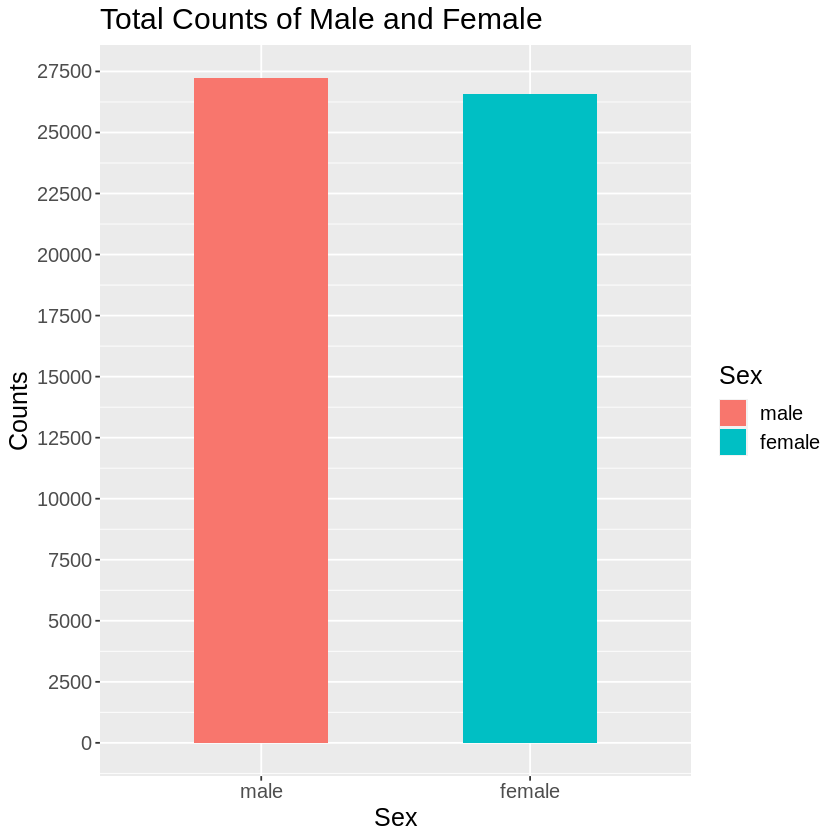

In [138]:
sex_plot <- sex_summary |>
    ggplot(aes(x = sex, y = count, fill = sex)) +
    geom_bar(stat = "identity", width = 0.5) +
    scale_y_continuous(breaks=seq(0, 27500, by = 2500)) +
    labs(x = "Sex", y = "Counts", fill = "Sex") +
    theme(text = element_text(size = 15)) +
    ggtitle("Total Counts of Male and Female")
    
sex_plot
print("Figure 2.2 - Number of men and women in the dataset")

We can see that the number of man and woman in the survey are roughly equal and that the sample size for each group is quite large.

## Hourly Wage 

In [139]:
hrwage_summary <- pay_data %>%
    group_by(sex) %>%
    summarize(mean_wage = mean(hrwage))
hrwage_summary
print("Table 2.3 - Mean wage for men and women")

sex,mean_wage
<fct>,<dbl>
male,28.844
female,21.924


[1] "Table 2.3 - Mean wage for men and women"


Warning message:
“Removed 1186 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 rows containing missing values (geom_bar).”


[1] "Figure 2.4 - Sample distribution of hourly wage for men and women"


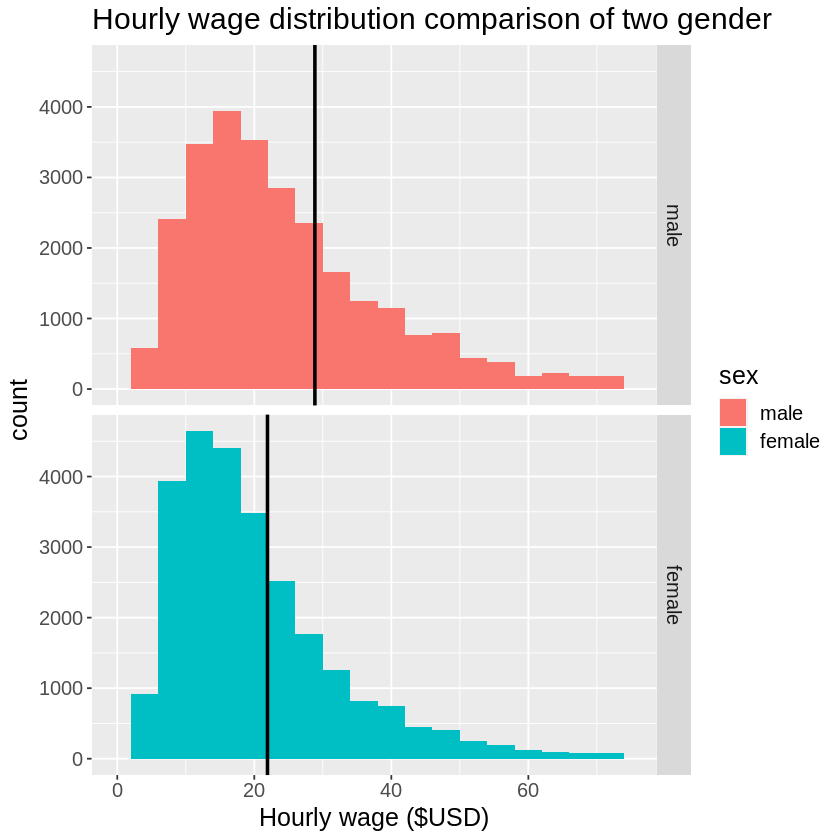

In [140]:
hrwage_plot <- pay_data %>%
  ggplot() +
  geom_histogram(aes(x = hrwage, fill = sex), binwidth = 4) +
  geom_vline(data = hrwage_summary, mapping = aes(xintercept = mean_wage), size = 1) +
  facet_grid(vars(sex)) + 
  xlim(0, 75) + xlab("Hourly wage ($USD)") + 
  ggtitle("Hourly wage distribution comparison of two gender") +
  theme(text = element_text(size = 15))
hrwage_plot
print("Figure 2.4 - Sample distribution of hourly wage for men and women")

From the table and plot above, we can see that the mean wage for men is higher than women for this sample, at around $7 more.

## Hypothesis Testing - Asymptotic Method

For the rest of the report, we originally inteded to use the whole sample to perform the hypothesis test. Unfortunately, due to the limitation in computational power, we will only take a subset of the original sample. We take both groups to be the same size of 500 since the original sample is evenly split between the two groups.

In [141]:
set.seed(2345)
sample <- 
    data %>%
    group_by(sex) %>%
    sample_n(size = case_when(sex == "male" ~ 500,
                              sex == "female" ~ 500),
             replace = FALSE) %>%
    ungroup()
head(sample)
print("Table 3.1 - First few observations of the subsetted sample")

sex,hrwage
<fct>,<dbl>
male,24.556
male,44.231
male,19.231
male,96.154
male,72.115
male,19.118


[1] "Table 3.1 - First few observations of the subsetted sample"


[1] "Figure 3.2"


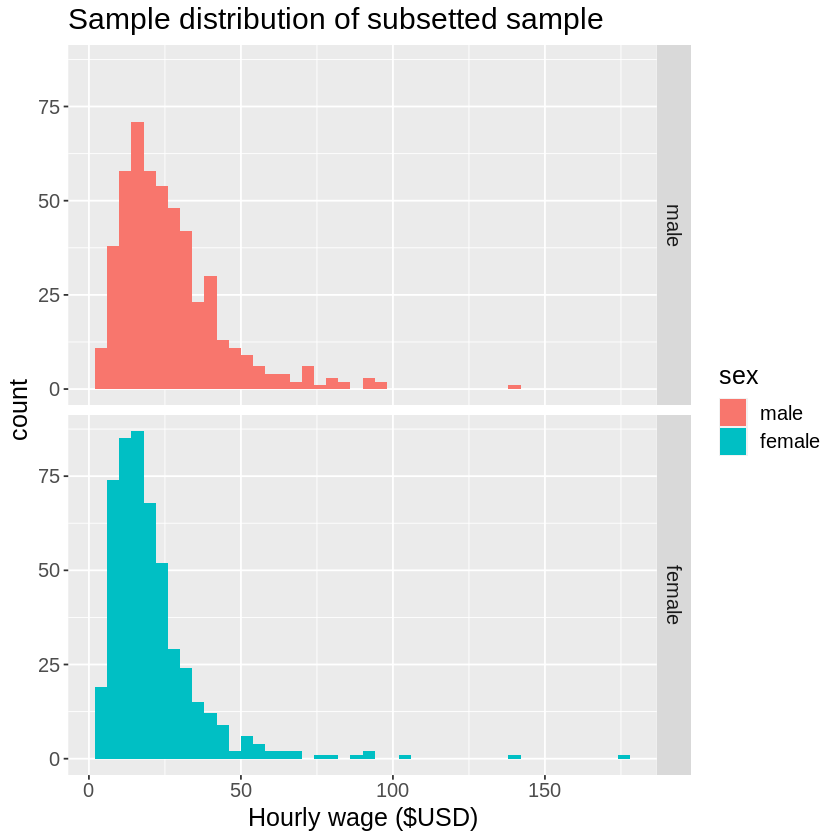

In [142]:
samp_dist_plot <- 
    sample %>% 
    ggplot() + 
    geom_histogram(aes(x = hrwage, fill = sex), binwidth = 4) +
    facet_grid(vars(sex)) + 
    theme(text = element_text(size = 15)) +
    ggtitle("Sample distribution of subsetted sample") + 
    xlab("Hourly wage ($USD)")

samp_dist_plot
print("Figure 3.2")

Here we visualize the distribution of our subsetted sample. The shape of the distribution is roughly similar to our original sample in the previous section with it being right-skewed and the peak for women is lower than that of men. Next let's perform the hypthothesis test using asymptotic method.

The code above conducts a two-sample t-test for comparing the means of 'hrwage' (hourly wage) between male and female groups. It summarizes the necessary statistics for each group, calculates the mean difference and the standard error of the difference, and then computes the p-value for the t-test, storing the results in the `t_test_summary` dataframe.

In [158]:
t_test <-  t.test(sample %>% filter(sex == "male") %>% pull(hrwage),
                  sample %>% filter(sex == "female") %>% pull(hrwage),
                  alternative = "greater") %>%
    tidy()
  
t_test
print("Table 3.3 - Results of two-sample t-test")

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
5.6965,26.869,21.172,5.3584,5.2183e-08,994.14,3.9462,Inf,Welch Two Sample t-test,greater


[1] "Table 3.3 - Results of two-sample t-test"


We perform a two-sample t-test using the built-in `t.test` function with the alternative hypothesis being $\mu_{\text{male}} > \mu_{\text{female}}$. We can use the t-test here because we satisfies the assumptions of the Central Limit Theorem. Our sample is randomly drawn and independent of each other; the estimator is indeed a random sum of components; although our distribution isn't Gaussian, we can rely on the fact that our sample size is quite large. We can see that the p-value is very small, 5.2e-8.

In [159]:
sample_summary <- 
    sample %>%
    group_by(sex) %>%
    summarise(sample_mean = mean(hrwage),
             sample_std_error = sd(hrwage)/sqrt(n()))
sample_summary
print("Table 3.4 - Sample mean and standard error of the two groups")

sex,sample_mean,sample_std_error
<fct>,<dbl>,<dbl>
male,26.869,0.77479
female,21.172,0.72792


[1] "Table 3.4 - Sample mean and standard error of the two groups"


The code calculates the mean and standard error of the 'hrwage' variable grouped by 'sex' in the 'sample' data frame using the dplyr package in R.

In [162]:
ci = 0.95

male_mean <- sample_summary$sample_mean[1]
male_var <- sample_summary$sample_std_error[1]^2
female_mean <- sample_summary$sample_mean[2]
female_var <- sample_summary$sample_std_error[2]^2

parking_clt_ci <- 
    tibble(lower_ci = (male_mean - female_mean - qnorm(1- (1-ci)/2) * sqrt(female_var + male_var)),
           upper_ci = (male_mean - female_mean + qnorm(1- (1-ci)/2) * sqrt(female_var + male_var)))

head(parking_clt_ci)
print("Table 3.5 - 95% confidence interval for difference in mean wages (Asymptotic method)")

lower_ci,upper_ci
<dbl>,<dbl>
3.6128,7.7801


[1] "Table 3.5 - 95% confidence interval for difference in mean wages (Asymptotic method)"


The code above calculates a confidence interval at a 95% confidence level for the difference between the means of male and female parking samples using the Central Limit Theorem (CLT). It computes the lower and upper bounds of the confidence interval and stores the results in a tibble called `parking_clt_ci`.

## Hypothesis Testing - Bootstrapping Method

In this section, we will perform hypothesis test on the subsetted sample from the previous section but using the bootstrapping method.

In [163]:
set.seed(2370)
diff_in_means <- sample |>
    specify(formula = hrwage ~ sex) |>
    generate(reps = 10000, type = "bootstrap") |>
    calculate(stat = "diff in means", order = c("male", "female"))

#Calculating confidence interval for the bootstrap sampling distribution
bootstrap_ci <- diff_in_means |> 
  get_confidence_interval(level = 0.95, type = "percentile")
bootstrap_ci
print("Table 4.1 - 95% confidence interval for difference in mean wages (Bootstrapping method)")

lower_ci,upper_ci
<dbl>,<dbl>
3.5863,7.7593


[1] "Table 4.1 - 95% confidence interval for difference in mean wages (Bootstrapping method)"


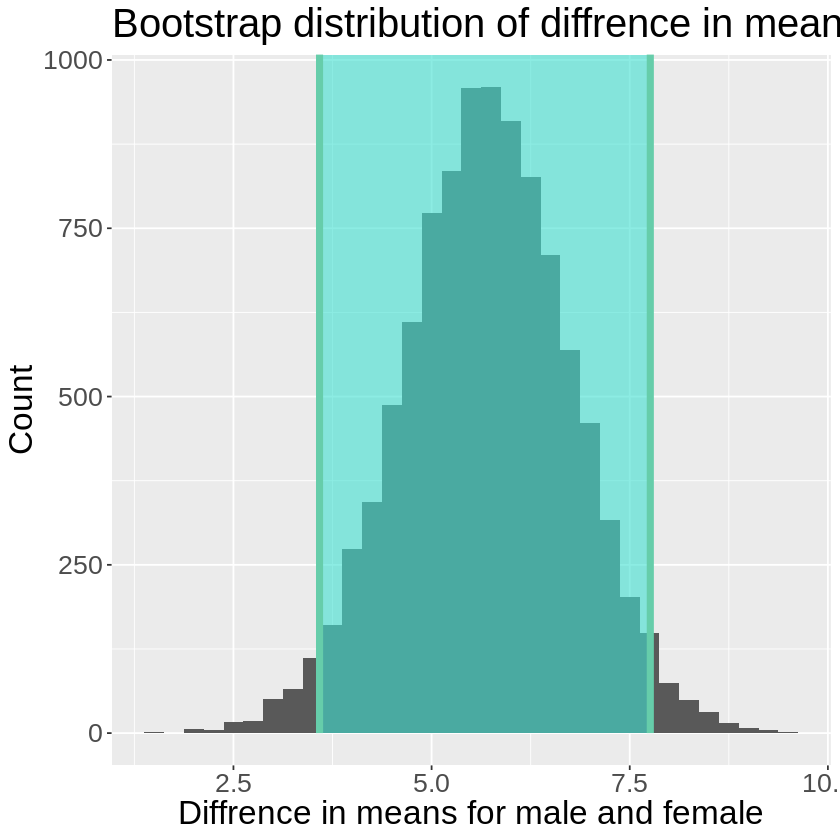

In [148]:
bootstrap_dist <- diff_in_means |>
    ggplot(aes(x = stat)) +
    geom_histogram(binwidth = 0.25) +
    labs(x = "Diffrence in means for male and female", y = "Count") +
    ggtitle("Bootstrap distribution of diffrence in means for male and female") +
    theme(text = element_text(size = 20)) +
    shade_confidence_interval(endpoints = bootstrap_ci)

bootstrap_dist

We have now generated a histogram plot using ggplot, depicting the bootstrap distribution of the difference in means between male and female groups, with shaded confidence intervals.

In [149]:
#creating a null distirbution 
null_diff_means <- sample |>
    specify(formula = hrwage ~ sex) |>
    hypothesize(null = "independence") |>
    generate(reps = 10000, type = "permute") |>
    calculate(stat = "diff in means", order = c("male", "female"))
head(null_diff_means)

replicate,stat
<int>,<dbl>
1,-1.06838
2,-0.27330
3,0.13155
4,-0.33406
5,-1.54673
6,-1.11371


We have now created a null distribution by shuffling gender labels within the 'hrwage' dataset and then computes differences in means between male and female categories. This process is repeated 10,000 times for statistical analysis.

In [150]:
#Computing an observed statistic
obs_diff_means <- sample %>% 
  specify(formula = hrwage ~ sex) %>% 
  calculate(stat = "diff in means", order = c("male", "female"))
obs_diff_means

stat
<dbl>
5.6965


7.065363 is the observed difference in means of hourly wages between male and female groups using a given dataset.

In [151]:
#computing p-value
options(digits = 5)

p_value <- null_diff_means %>% 
  get_p_value(obs_stat = obs_diff_means, direction = "both")
p_value
#p-value turned out to be 0.. are we sure?

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


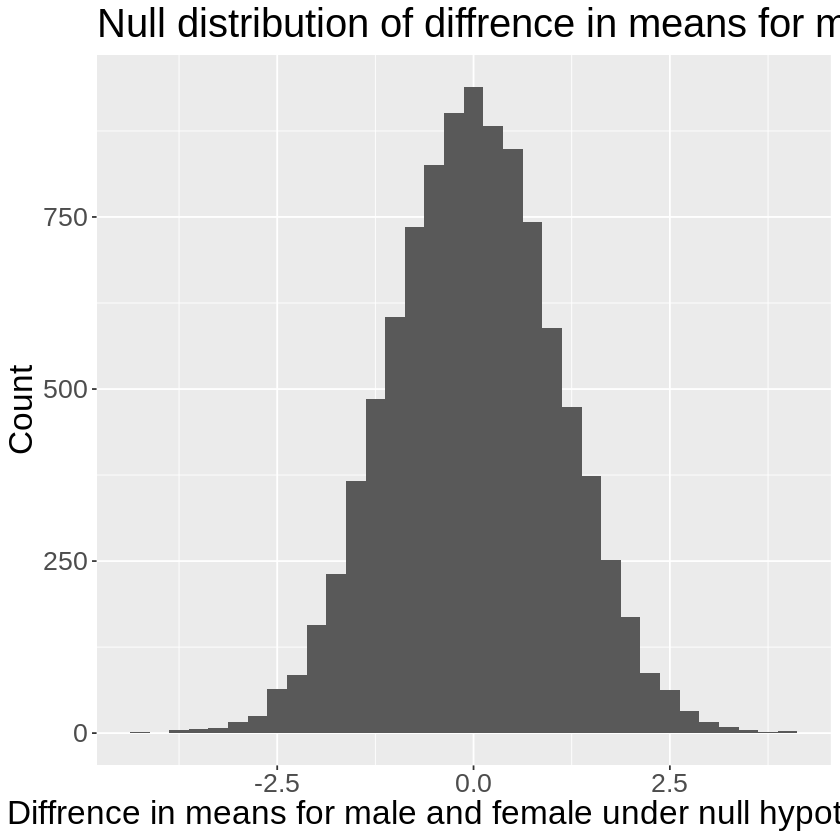

In [152]:
null_distribution <- null_diff_means |>
    ggplot(aes(x = stat)) +
    geom_histogram(binwidth = 0.25) +
    labs(x = "Diffrence in means for male and female under null hypothesis", y = "Count") +
    ggtitle("Null distribution of diffrence in means for male and female") +
    theme(text = element_text(size = 20))
null_distribution
#p-value of 0 could not be visualized..

## Reflecting on how the final report might play out

**Expected Findings:**
We expect to find that female workers earn less median hourly wages than their male counterparts. Additionally, we may anticipate uncovering variations in wage gaps across different racial groups, providing deeper insights into intersectional inequalities.

**Impact of Findings:**
Highlighting the gender wage gap can serve as a call to action for policymakers, employers, and advocates to address this pressing issue. By quantifying the existence of disparities, our study can contribute to the ongoing efforts towards gender equality in the workforce. 

**Future Question:**
Wage Gap in Different Industries: Investigating the wage gap across various industries and occupations could help identify sectors with more significant disparities and guide targeted interventions.

# References

1) Deep B. (2021). Gender Pay Gap Dataset. Kaggle. Retrieved from: https://www.kaggle.com/code/deepbdoshi/gender-pay-gap

2) Blau, F. D., & Kahn, L. M. (2017). The Gender Wage Gap: Extent, Trends, and Explanations. Journal of Economic Literature, 55(3), 789–865. http://www.jstor.org/stable/26303306

3) Pew Research Center. (March 1, 2023). Gender Pay Gap Facts. Pew Research Center. Retrieved from https://www.pewresearch.org/short-reads/2023/03/01/gender-pay-gap-facts/